In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib notebook

In [2]:
import time

def get_fitted_line_data(series):
    """
    Returns (slope, intercept, xaxis) of the line that best fits the series.
    See: http://glowingpython.blogspot.com/2012/03/linear-regression-with-numpy.html
    """
    xaxis = np.array([
        time.mktime(
            dt.replace(hour=0, minute=0, second=0, microsecond=0).timetuple()
        ) for dt in series.index.to_pydatetime()
    ])
    A = np.vstack([xaxis, np.ones(len(xaxis))]).T
    yaxis = series.values
    m, c = np.linalg.lstsq(A, yaxis)[0]
    return (m, c, xaxis)

def fit_line(series):
    """
    Returns a series that represents the line that best fits the data.
    """
    m, c, xaxis = get_fitted_line_data(series)
    return (m * xaxis + c)

def calculate_timeseries_slope(df, series_name, time_unit='days'):
    """
    df: Dataframe containing the time series.
    series_name: column name that contains the linear series.
    time_units: Calculate the slope as change in series units / change in time_units (default 'days').
    """
    ix = df.tail(2).index
    vals = ix.to_pydatetime()
    dt0 = vals[0]
    dt1 = vals[1]
    td = dt1 - dt0
    days = getattr(td, time_unit)
    line_series = df[series_name]
    p0 = line_series[-2]
    p1 = line_series[-1]
    delta = p1 - p0
    slope = float(delta) / float(days)
    return slope

In [3]:
import random

def line_func(x, m, c):
    return m*x + c

ix = pd.date_range('2015-10-01', '2015-11-01', freq='1D')
m = -100.5
data = [line_func(x, m, 7000) + random.randint(-5, 5)*abs(m) for x in range(len(ix))]
df = pd.DataFrame(data, index=ix, columns=['data'])
df.head()

,data
2015-10-01,6799.0
2015-10-02,7000.0
2015-10-03,7301.5
2015-10-04,6899.5
2015-10-05,7100.5


<IPython.core.display.Javascript object>


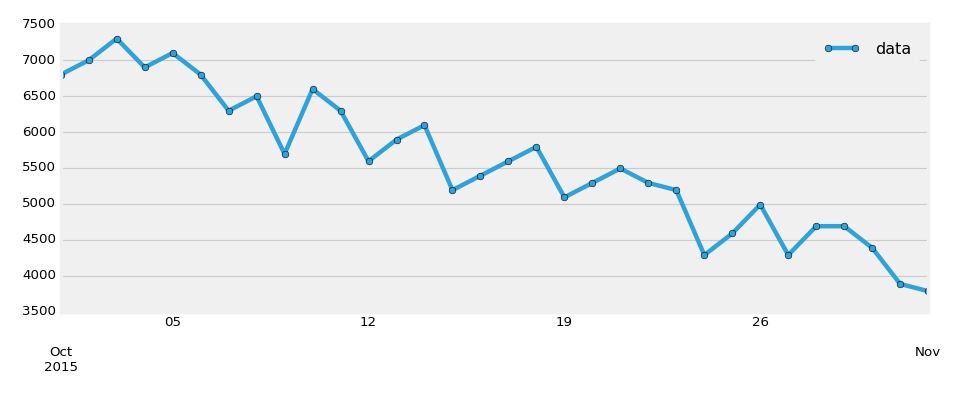

In [4]:
with plt.style.context(('fivethirtyeight')):
    df.plot(figsize=(12, 5), marker='o')
    fig = plt.gcf()
    fig.tight_layout()

<IPython.core.display.Javascript object>


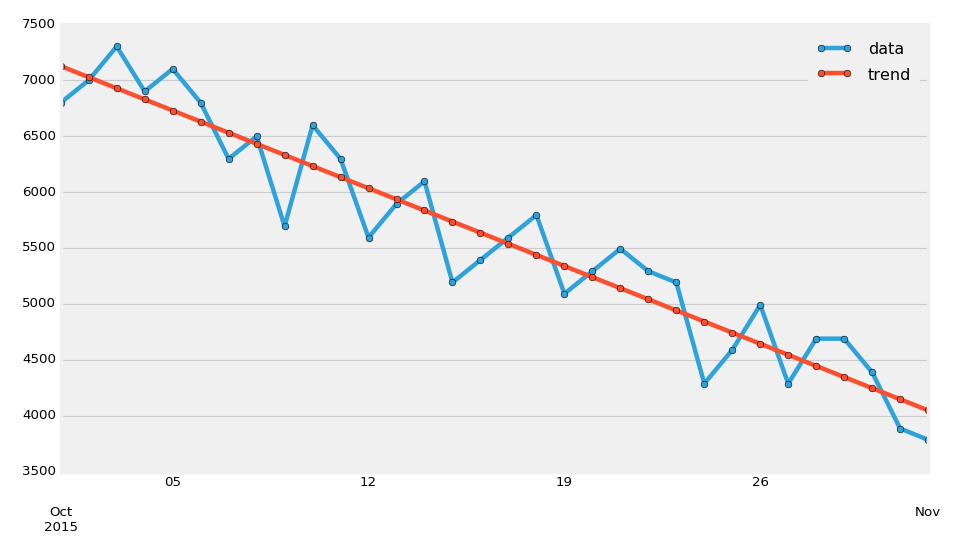

In [5]:
with plt.style.context(('fivethirtyeight')):
    trend = df.copy()
    trend["trend"] = fit_line(trend["data"])
    trend.plot(figsize=(12, 7), marker='o')
    fig = plt.gcf()
    fig.tight_layout()

For points (x0, y0) and (x1, y1) on a line, the slope is equal to

$$ 
m = \frac{(y1 - y0)}{(x1 - x0)}
$$

Since we know the slope, and point (x0, y0), we can create a function to find any y given an x.


In [6]:
import datetime
import random

def dateindex2timestamps(series):
    return np.array([
        time.mktime(
            dt.replace(hour=0, minute=0, second=0, microsecond=0).timetuple()
        ) for dt in series.index.to_pydatetime()
    ])

def line_series_to_func(line_series):
    xseries = dateindex2timestamps(line_series)
    yseries = line_series.values
    choice_0 = random.randint(0, len(xseries) - 1)
    choice_1 = choice_0
    while choice_1 == choice_0:
        choice_1 = random.randint(0, len(xseries) - 1)
    y0 = yseries[choice_0]
    x0 = xseries[choice_0]
    y1 = yseries[choice_1]
    x1 = xseries[choice_1]
    m = (y1 - y0) / (x1 - x0)
    
    def _line_func(x):
        return m * (x - x0) + y0
    
    def _rline_func(y):
        return ((y - y0) / m) + x0
        
    return (_line_func, _rline_func)
  

In [7]:
def add_prediction(df, predict_date=None, predict_value=None, datacol='data', trendcol='trend', freq=None):
    """
    Extend a trend line for a prediction.
    """
    assert not ((predict_date is None) and (predict_value is None)), "Must have `predict_date` or `predict_value`."
    table = df.copy()
    fn, rfn = line_series_to_func(table[trendcol])
    last_known_date = table.index.max()
    if predict_date is None:
        predict_date = datetime.datetime.fromtimestamp(rfn(predict_value))
    if freq is None:
        freq = table.index.freq
    ix = pd.date_range(table.index.min(), predict_date, freq=freq)
    table = table.reindex(ix)
    table[:last_known_date] = table[:last_known_date].fillna(method='ffill')
    table["prediction"] = [fn(ts) for ts in dateindex2timestamps(table[datacol])]
    table["prediction"][ix < last_known_date] = np.nan
    return table, fn, rfn

<IPython.core.display.Javascript object>


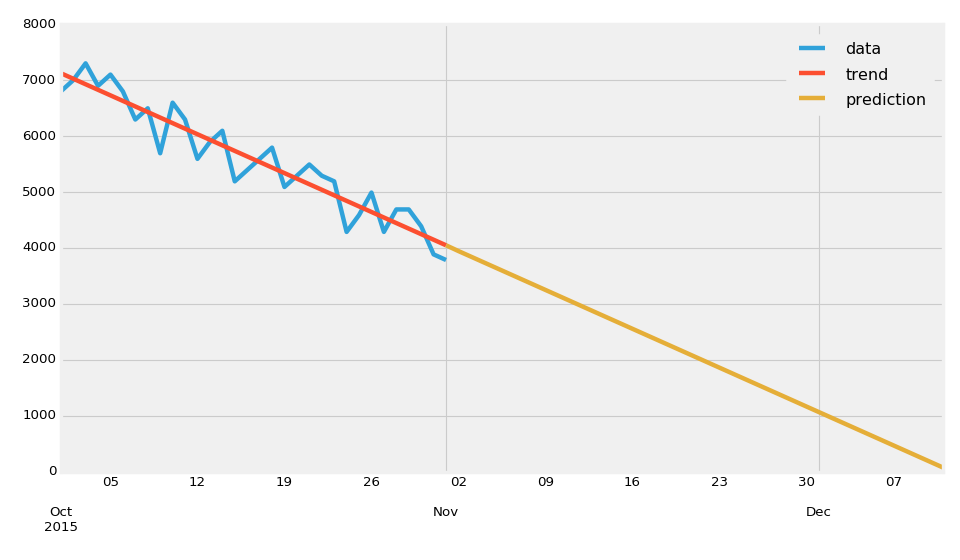

x-intercept: Dec 11, 2015


In [8]:
table, fn, rfn = add_prediction(trend, predict_value=0.0)
with plt.style.context(('fivethirtyeight')):
    table.plot(figsize=(12, 7))
    fig = plt.gcf()
    fig.tight_layout()
x_intercept = datetime.datetime.fromtimestamp(rfn(0.0))
print("x-intercept: {0}".format(x_intercept.strftime("%b %d, %Y")))